In [1]:
%matplotlib inline
!mkdir -p figs

In [2]:
import matplotlib.pyplot as plt
import seaborn as sn
sn.set_context("poster")

import torch
from torch import nn as nn
ttype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor
ctype = torch.cuda.LongTensor if torch.cuda.is_available() else torch.LongTensor
print(ttype)
import torch.nn.functional as F
from matplotlib import gridspec
from sithcon import TCTCT_Layer as SITHCon_Layer, _TCTCT_Core as _SITHCon_Core, iSITH

from tqdm.notebook import tqdm

import itertools
from csv import DictWriter
import os 
from os.path import join
import glob

import numpy as np
import pandas as pd
import pickle
from math import factorial
import random
import matplotlib.patches as patches
from itertools import combinations_with_replacement as comb


<class 'torch.cuda.FloatTensor'>


/N/soft/rhel7/xalt/2.10.30/libexec/xalt_record_pkg: invalid option -- 'A'
/N/soft/rhel7/xalt/2.10.30/libexec/xalt_record_pkg: invalid option -- 'A'
/N/soft/rhel7/xalt/2.10.30/libexec/xalt_record_pkg: invalid option -- 'A'
/N/soft/rhel7/xalt/2.10.30/libexec/xalt_record_pkg: invalid option -- 'I'
/N/soft/rhel7/xalt/2.10.30/libexec/xalt_record_pkg: invalid option -- '/'


In [3]:
# SHORTER
MORSE_CODE_DICT = {'1':'.-', '2':'-...', 
                    '3':'-.-.', '4':'-..', '5':'.', 
                    '6':'..-.', '7':'--.', '8':'....', 
                    '9':'..', '0':'.---',}

In [4]:
morse_code_numpy = {key:np.array([int(x) for x in MORSE_CODE_DICT[key].replace('.', '10').replace('-', '1110')] + [0, 0])
                    for key in MORSE_CODE_DICT.keys()}
for k in morse_code_numpy.keys():
    print(morse_code_numpy[k], k)
subset = list(morse_code_numpy.keys())

[1 0 1 1 1 0 0 0] 1
[1 1 1 0 1 0 1 0 1 0 0 0] 2
[1 1 1 0 1 0 1 1 1 0 1 0 0 0] 3
[1 1 1 0 1 0 1 0 0 0] 4
[1 0 0 0] 5
[1 0 1 0 1 1 1 0 1 0 0 0] 6
[1 1 1 0 1 1 1 0 1 0 0 0] 7
[1 0 1 0 1 0 1 0 0 0] 8
[1 0 1 0 0 0] 9
[1 0 1 1 1 0 1 1 1 0 1 1 1 0 0 0] 0


In [5]:
def gen_item_noisy(samples=10, scale=5, target_scale=.1, display=False):
    # We can tests 1s the same length as the items added together or 1 at the end only.
    keys = morse_code_numpy.keys()
    dim1 = []
    dim2 = []
    half = int(samples / 2)
    added_indexes = [np.random.randint(half),  
                     np.random.randint(half, samples)]
    answer = 0
    double_prob = 1/4

    for s in range(samples):
        # Grab Random Morse Code Letter
        k = random.sample(keys, 1)[0]
        mcl = morse_code_numpy[k]

        Mmcl = mcl.repeat(scale)
        dim1.append(Mmcl[:, np.newaxis])
        if s in added_indexes:
            
            # dim2.append(np.ones(Mmcl.shape[0])[:, np.newaxis])
            temp = np.zeros(Mmcl.shape[0])[:, np.newaxis]
            temp[-scale:] = 1.0
            if display:
                    temp = temp * 2.0
            #temp[-1] = 1.0 # TRY THIS AT SOME POINT
            dim2.append(temp)
            answer += int(k)
            if display:
                dim1[-1] = dim1[-1]*2.0
        else:
            dim2.append(np.zeros(Mmcl.shape[0])[:, np.newaxis])
    inp = np.concatenate([np.concatenate(dim1, axis=0),
                          np.concatenate(dim2, axis=0)], axis=1)
    
    inp_list = []
    for x in inp:
        inp_list.append(x)
        if random.random() < double_prob:
            inp_list.append(x)
    
    inp = np.stack(inp_list)

    target = np.array([answer])
    return inp, target*target_scale

/tmp/ipykernel_96809/3498076752.py:14: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  k = random.sample(keys, 1)[0]


(568, 2)


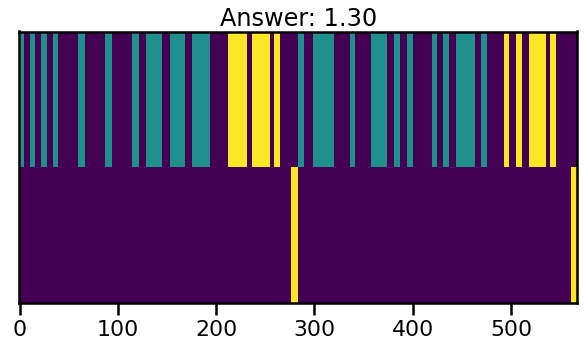

In [6]:
def gen_item(samples=10, scale=5, target_scale=.1, display=False):
    # We can tests 1s the same length as the items added together or 1 at the end only.
    keys = morse_code_numpy.keys()
    dim1 = []
    dim2 = []
    half = int(samples / 2)
    added_indexes = [np.random.randint(half),  
                     np.random.randint(half, samples)]
    
    answer = 0
    for s in range(samples):
        # Grab Random Morse Code Letter
        k = random.sample(keys, 1)[0]
        mcl = morse_code_numpy[k]
        Mmcl = mcl.repeat(scale)
        dim1.append(Mmcl[:, np.newaxis])
        if s in added_indexes:
            
            # dim2.append(np.ones(Mmcl.shape[0])[:, np.newaxis])
            temp = np.zeros(Mmcl.shape[0])[:, np.newaxis]
            temp[-scale:] = 1.0
            if display:
                    temp = temp * 2.0
            #temp[-1] = 1.0 # TRY THIS AT SOME POINT
            dim2.append(temp)
            answer += int(k)
            if display:
                dim1[-1] = dim1[-1]*2.0
        else:
            dim2.append(np.zeros(Mmcl.shape[0])[:, np.newaxis])
    inp = np.concatenate([np.concatenate(dim1, axis=0),
                          np.concatenate(dim2, axis=0)], axis=1)
    
    target = np.array([answer])
    return inp, target*target_scale
inp, tar = gen_item_noisy(10, 5, .1, display=True)
print(inp.shape)
plt.figure(figsize=(10,5))
plt.imshow(inp.T,aspect='auto', interpolation='none')
plt.title("Answer: {:.2f}".format(tar[0]))
plt.yticks([])
plt.savefig(join('figs', 'adding_morse_example'), dpi=100)

In [7]:
class SITHCon_Classifier(nn.Module):
    def __init__(self, out_classes, layer_params, 
                 act_func=nn.ReLU, batch_norm=False,
                 dropout=.2):
        super(SITHCon_Classifier, self).__init__()
        last_channels = layer_params[-1]['channels']
        self.transform_linears = nn.ModuleList([nn.Linear(l['channels'], l['channels'])
                                                for l in layer_params])
        self.sithcon_layers = nn.ModuleList([SITHCon_Layer(l, act_func) for l in layer_params])
        self.to_out = nn.Linear(last_channels, out_classes)
        
        
    def forward(self, inp):
        
        x = inp
        #out = []
        for i in range(len(self.sithcon_layers)):
            x = self.sithcon_layers[i](x)
            
            x = F.relu(self.transform_linears[i](x[:,0,:,:].transpose(1,2)))
            x = x.unsqueeze(1).transpose(2,3)

            #out.append(x.clone())
        x = x.transpose(2,3)[:, 0, :, :]
        #x = x.transpose(2,3)[:, 0, :, :]
        x = self.to_out(x)
        return x

# Three Layers

In [8]:
params = [[3000, 400, 35, 23, 2, 6000],]

In [9]:
def gen_model(p):
    sp1 = dict(in_features=2, 
               tau_min=.1, tau_max=p[0], buff_max=p[5],
               dt=1, ntau=p[1], k=p[2], g=0.0, ttype=ttype, 
               channels=25, kernel_width=p[3], dilation=p[4],
               dropout=None, batch_norm=None)
    sp2 = dict(in_features=sp1['channels'], 
               tau_min=.1, tau_max=p[0], buff_max=p[5],
               dt=1, ntau=p[1], k=p[2], g=0.0, ttype=ttype, 
               channels=25, kernel_width=p[3], dilation=p[4], 
               dropout=None, batch_norm=None)
    sp3 = dict(in_features=sp2['channels'], 
               tau_min=.1, tau_max=p[0], buff_max=p[5],
               dt=1, ntau=p[1], k=p[2], g=0.0, ttype=ttype, 
               channels=25, kernel_width=p[3], dilation=p[4], 
               dropout=None, batch_norm=None)
    layer_params = [sp1, sp2, sp3]
    model = SITHCon_Classifier(1, layer_params, act_func=None
                              ).cuda()
    return model

def save_outcome(outcome, filename):
    dat = pd.DataFrame(outcome)
    dat.to_csv(join('perf',filename))

In [10]:
model = gen_model(params[0])
tot_weights = 0
for p in model.parameters():
    tot_weights += p.numel()
print("Total Weights:", tot_weights)
print(model)

Total Weights: 32101
SITHCon_Classifier(
  (transform_linears): ModuleList(
    (0): Linear(in_features=25, out_features=25, bias=True)
    (1): Linear(in_features=25, out_features=25, bias=True)
    (2): Linear(in_features=25, out_features=25, bias=True)
  )
  (sithcon_layers): ModuleList(
    (0): TCTCT_Layer(
      (tctct): _TCTCT_Core(
        (sith): iSITH(ntau=400, tau_min=0.1, tau_max=3000, buff_max=6000, dt=1, k=35, g=0.0)
        (conv): Conv2d(1, 25, kernel_size=(2, 23), stride=(1, 1), dilation=(1, 2), bias=False)
        (maxp): MaxPool1d(kernel_size=356, stride=356, padding=0, dilation=1, ceil_mode=False)
      )
      (batch_norm): BatchNorm1d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (1): TCTCT_Layer(
      (tctct): _TCTCT_Core(
        (sith): iSITH(ntau=400, tau_min=0.1, tau_max=3000, buff_max=6000, dt=1, k=35, g=0.0)
        (conv): Conv2d(1, 25, kernel_size=(25, 23), stride=(1, 1), dila

In [11]:
  loss_func = nn.MSELoss()

In [12]:
Trainscale = 5
epochs = 40
trials_per_epoch = 1000
batch_size = 32
device='cuda'
runs = 1
history = []
for r in range(runs):
    model = gen_model(params[0])
    model.load_state_dict(torch.load(join('','SITHCon_morseadding_run_{}.pt'.format(r))))
    optimizer = torch.optim.Adam(model.parameters())


    progress_bar = tqdm(range(int(epochs)), bar_format='{l_bar}{bar:5}{r_bar}{bar:-5b}')

    for epoch_idx in progress_bar:
        perfs = []
        losses = []
        model.train()
        for batch_idx in range(trials_per_epoch):
            optimizer.zero_grad()
            loss = 0
            for i in range(batch_size):
                iv, tar = gen_item(10,Trainscale, .1)
                iv = ttype(iv).unsqueeze(0).unsqueeze(0).transpose(-1,-2)
                tv = ttype(tar)
                out = model(iv)
                loss += loss_func(out[:, -1, :],
                                 tv)
                #print((torch.round(out[:, -1, :] * 10) / 10), tv)
                perf = (torch.round(out[:, -1, :] * 10) / 10).item() == round(tv.item())
                perfs.append(perf)
                del iv, tar, out
            loss = loss / batch_size
            loss.backward()
            optimizer.step()

            
            #perfs = perfs[int(-loss_buffer_size/batch_size):]
            losses.append(loss.detach().cpu().numpy())
            #losses = losses[int(-loss_buffer_size/batch_size):]
            
            perf_avg = np.sum(perfs)/((len(perfs)))
            s = "{}:{:2} Loss: {:.4f}, Perf: {:.4f}"
            format_list = [epoch_idx, batch_idx, np.mean(losses), perf_avg.item()]
            s = s.format(*format_list)
            progress_bar.set_description(s)
            if batch_idx % 100 == 0:
                f = open(f"history_{r}.p", "wb")
                pickle.dump(history, f)
                torch.save(model.state_dict(), 'SITHCon_morseadding_run_{}.pt'.format(r))
        history.append(sum(losses) / trials_per_epoch)
        

  0%|     | 0/40 [00:00<?, ?it/s]     

/tmp/ipykernel_96809/1754652697.py:13: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  k = random.sample(keys, 1)[0]
/N/soft/rhel7/deeplearning/Python-3.9.6/lib/python3.9/site-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)
/N/soft/rhel7/deeplearning/Python-3.9.6/lib/python3.9/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


KeyboardInterrupt: 

# Test

In [ ]:
items = np.load('generated_adding_morse.npy', allow_pickle=True)

In [14]:
runs = 5
device='cuda'
num_items = 300
for r in [0]:
    model.load_state_dict(torch.load('SITHCon_morseadding_run_{}.pt'.format(r)))
    model.eval()
    evald = []
    evaldDict = {'test_perf':[],
                 'rate':[]}
    
    with torch.no_grad():
        for nr in [1,3,4,5,6,12,25,50]:
        #for nr in range(1,40,):
            losses = []
            perfs = []
            for i in range(num_items):
                iv, tar = gen_item(10,nr, .1)

                iv = ttype(iv).unsqueeze(0).unsqueeze(0).transpose(-1,-2).unsqueeze(-1)
                iv = iv.repeat(1,1,1,1,nr)
                iv = iv.reshape(1,1,2,-1)
                tv = torch.FloatTensor(tar).to(device)
                out = model(iv)

                loss = loss_func(out[:, -1, :],
                                     tv)
                losses.append(loss.detach().cpu().numpy())
            print(nr, np.mean(losses))
            evaldDict['test_perf'].append(np.mean(losses))
            evaldDict['rate'].append(nr)
            evald.append([nr, np.mean(losses)])
        scale_perfs = pd.DataFrame(evaldDict)
        scale_perfs.to_pickle(join("perf", "sithcon_morseadding_test_{}.dill".format(r)))

/tmp/ipykernel_96809/1754652697.py:13: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  k = random.sample(keys, 1)[0]


1 0.16549301
3 0.10222519
4 0.102583416
5 0.14806679
6 0.1617673


KeyboardInterrupt: 

In [ ]:
params = [[3000, 400, 35, 23, 2, 6000],]
model = gen_model(params[0])
tot_weights = 0
for p in model.parameters():
    tot_weights += p.numel()
print("Total Weights:", tot_weights)
print(model)
c = model.sithcon_layers[0].sithcon.sith.c
print(c)
ntau = 300
m = .1
maxt = m*(c+1)**(ntau-1)
params.append([maxt, ntau, 35, 23, 2, maxt*3])
ntau = 350
maxt = m*(c+1)**(ntau-1)
params.append([maxt, ntau, 35, 23, 2, maxt*3])
ntau = 450
maxt = m*(c+1)**(ntau-1)
params.append([maxt, ntau, 35, 23, 2, maxt*3])
ntau = 500
maxt = m*(c+1)**(ntau-1)
params.append([maxt, ntau, 35, 23, 2, maxt*3])

In [ ]:
perfs = []
for p in params[-1:]:
    
    model = gen_model(p)
    model.load_state_dict(torch.load(join('perf','SITHCon_morseadding_run_{}.pt'.format(0))))
    model.eval()
    evald = []
    evaldDict = {'test_perf':[],
                 'rate':[]}

    with torch.no_grad():
        for nr in [150]:
        #for nr in range(1,40,):
            losses = []
            perfs = []
            for iv, tar in items:
                iv = ttype(iv).unsqueeze(0).unsqueeze(0).transpose(-1,-2).unsqueeze(-1)
                iv = iv.repeat(1,1,1,1,nr)
                iv = iv.reshape(1,1,2,-1)
                tv = torch.FloatTensor(tar).to(device)
                out = model(iv)

                loss = loss_func(out[:, -1, :],
                                     tv)
                losses.append(loss.detach().cpu().numpy())
            print(nr, np.mean(losses))
            evaldDict['test_perf'].append(np.mean(losses))
            evaldDict['rate'].append(nr)
            evald.append([nr, np.mean(losses)])
    scale_perfs = pd.DataFrame(evaldDict)
    perfs.append(scale_perfs)    